# Dataset preparation for interpolation, feature grouping by station
- Preparation of the dataset before Kalman interpolation (out of the scope of this notebook)
- Further preparation of the dataset after Kalman interpolation

## Pre-Interpolation
- Renaming of columns
- Detection of missing values

## Post-Interpolation
- Group features around stations originating the data
- Create new features around the grouping above: XYZ_Wind_dir, XYZ_Wind_speed, XYZ_Wind_max, XYZ_Hum, XYZ_Air_temp, XYZ_QNH,..., were prefix 'XYZ' corresponds to the abbreviation of the weather station 

In [ ]:
#pip install pykalman

In [1]:
# Custom scripts
import sys
sys.path.append('../04_scripts')
import constants as const
import data_handler as dh
import data_processor as dp
import xgb_handler as xh
import plot_handler as ph
import feature_handler as fh

#from pykalman import KalmanFilter
import numpy as np
from numpy import ma
import pandas as pd
import os
import re

In [2]:
os.getcwd()

'/Users/marco/projects/data_science/marco-folder/final_project_swiss/swiss-bise-project/02_notebooks'

In [9]:
pd.options.display.float_format = '{:,.3f}'.format # Limit output to 3 decimal places.
pd.set_option('display.max_columns', None)

In [38]:
stations_for_model=['BIZ','BUS','GUT','KLO','KOP','MOA','MUB', 'PAY','PUY','REH','SHA','SMA','TAE','WAE','WYN','VAD']

In [18]:
#df = dh.load_df_from_csv('weather_data_without_duplicates.csv')

In [9]:
df = pd.read_csv('../01_data/weather_data_without_duplicates.csv', sep =",")
df.head()

/Users/marco/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (2,3,4,5,6,7,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,,dkl010z0,fkl010z0,fkl010z1,pp0qffs0,pp0qnhs0,prestas0,stn,time,tre200s0,ure200s0
0,0,nan,138,3.900,5.600,"1,019.400","1,016.600",966.100,KLO,201401010000,-3.000,96.100
1,1,nan,149,3.300,5.700,"1,019.500","1,016.700",966.200,KLO,201401010010,-3.000,95.200
2,2,nan,145,3.100,4.400,"1,019.500","1,016.700",966.200,KLO,201401010020,-3.000,94.400
3,3,nan,127,3.700,4.600,"1,019.500","1,016.700",966.200,KLO,201401010030,-2.900,91.700
4,4,nan,131,4.100,5.000,"1,019.300","1,016.600",966.100,KLO,201401010040,-2.800,90.800


In [10]:
# subset the dataframe with the list of stations that we want to keep
df=df[df['stn'].isin(stations_for_model)]
df.reset_index(inplace=True)

In [11]:
# Rename the column names
df.rename(columns={'stn': 'Station', 'time': 'datetime', 'dkl010z0': 'Wind_dir', 'fkl010z0': 'Wind_speed',\
                   'fkl010z1': 'Wind_max', 'pp0qffs0': 'QFF', 'pp0qnhs0': 'QNH', 'prestas0': 'QFE',\
                   'tre200s0': 'Air_temp', 'ure200s0': 'Hum'}, inplace=True)
df.head()

,index,Unnamed: 0,,Wind_dir,Wind_speed,Wind_max,QFF,QNH,QFE,Station,datetime,Air_temp,Hum
0,0,0,nan,138,3.900,5.600,"1,019.400","1,016.600",966.100,KLO,201401010000,-3.000,96.100
1,1,1,nan,149,3.300,5.700,"1,019.500","1,016.700",966.200,KLO,201401010010,-3.000,95.200
2,2,2,nan,145,3.100,4.400,"1,019.500","1,016.700",966.200,KLO,201401010020,-3.000,94.400
3,3,3,nan,127,3.700,4.600,"1,019.500","1,016.700",966.200,KLO,201401010030,-2.900,91.700
4,4,4,nan,131,4.100,5.000,"1,019.300","1,016.600",966.100,KLO,201401010040,-2.800,90.800


In [12]:
# remove the first two columns
df.drop(columns=['Unnamed: 0', ''],inplace=True)
df.head()

,index,Wind_dir,Wind_speed,Wind_max,QFF,QNH,QFE,Station,datetime,Air_temp,Hum
0,0,138,3.900,5.600,"1,019.400","1,016.600",966.100,KLO,201401010000,-3.000,96.100
1,1,149,3.300,5.700,"1,019.500","1,016.700",966.200,KLO,201401010010,-3.000,95.200
2,2,145,3.100,4.400,"1,019.500","1,016.700",966.200,KLO,201401010020,-3.000,94.400
3,3,127,3.700,4.600,"1,019.500","1,016.700",966.200,KLO,201401010030,-2.900,91.700
4,4,131,4.100,5.000,"1,019.300","1,016.600",966.100,KLO,201401010040,-2.800,90.800


## Detect missing values, hyphens, to be replaced by NaNs

In [15]:
print('Number of missing wind direction values:')
print(len(df.loc[df['Wind_dir']=='-']))
print('Number of missing wind speed values:')
print(len(df.loc[df['Wind_speed']=='-']))
print('Number of missing wind max values:')
print(len(df.loc[df['Wind_max']=='-']))
print('Number of missing QFF values:')
print(len(df.loc[df['QFF']=='-']))
print('Number of missing QNH values:')
print(len(df.loc[df['QNH']=='-']))
print('Number of missing QFE values:')
print(len(df.loc[df['QFE']=='-']))
print('Number of missing air temperature values:')
print(len(df.loc[df['Air_temp']=='-']))
print('Number of missing humidity values:')
print(len(df.loc[df['Hum']=='-']))

Number of missing wind direction values:
9083
Number of missing wind speed values:
9024
Number of missing wind max values:
9337
Number of missing QFF values:
6304
Number of missing QNH values:
7781
Number of missing QFE values:
2610
Number of missing air temperature values:
6784
Number of missing humidity values:
6365


In [16]:
print('Number of missing wind values:')
print(len(df.loc[df['Wind_dir']=='-']))
df['flag_nulls'] = np.where(df['Wind_dir'] == '-', 1,0)
df['null_start_end']= df['flag_nulls'].diff()
null_start_index = df.loc[df['null_start_end']==1].index
null_end_index = df.loc[df['null_start_end']==-1].index
print('number of null events (ie wind readings = hyphen):')
print(len(null_start_index))
null_duration = null_end_index-null_start_index
print('duration of events where there are no wind readings:')
print(null_duration)

Number of missing wind values:
9083
number of null events (ie wind readings = hyphen):
38
duration of events where there are no wind readings:
Int64Index([ 129,   42,    3,  572,  184,  280,  149,   81,  191,   73,  171,
             137,   61, 1525,   45,    1,    3,    1,    1,    1,    1,    1,
               1,    1,    1,    1,    1,    1,    1, 2935,  175,  149,   50,
              64,  208,  231,  889,  723],
           dtype='int64')


In [17]:
index = 2
df[null_start_index[index]-5:null_end_index[index]+4]

,index,Wind_dir,Wind_speed,Wind_max,QFF,QNH,QFE,Station,datetime,Air_temp,Hum,flag_nulls,null_start_end
505540,505540,132,3.6,5.7,"1,010.100","1,012.300",960.000,REH,201808131630,22.400,71.200,0,0.000
505541,505541,143,3.3,5.3,"1,009.700","1,012.000",959.700,REH,201808131640,22.700,69.700,0,0.000
505542,505542,143,3.5,6.1,"1,009.500","1,011.800",959.500,REH,201808131650,22.600,70.900,0,0.000
505543,505543,143,3.4,6.0,"1,009.400","1,011.700",959.400,REH,201808131700,22.800,70.000,0,0.000
505544,505544,167,3.1,6.2,"1,009.500","1,011.800",959.500,REH,201808131710,23.000,65.900,0,0.000
505545,505545,-,-,-,"1,009.400","1,011.600",959.300,REH,201808131720,22.300,71.900,1,1.000
505546,505546,-,-,-,"1,011.000","1,012.500",960.200,REH,201808131730,19.000,76.100,1,0.000
505547,505547,-,-,-,"1,011.800","1,012.900",960.600,REH,201808131740,16.500,88.300,1,0.000
505548,505548,90,2.0,3.9,"1,011.800","1,012.800",960.500,REH,201808131750,16.300,89.500,0,-1.000
505549,505549,99,2.2,3.8,"1,011.700","1,012.700",960.400,REH,201808131800,16.400,92.500,0,0.000


### Replace all the hyphens with NaN

In [18]:
# Replace all the hypens with NaN
df = df.replace('-',np.nan)

# Convert all these columns to float
float_cols = ['Wind_dir', 'Wind_speed', 'Wind_max', 'QFF', 'QNH', 'QFE', 'Air_temp', 'Hum']
df[float_cols] = df[float_cols].astype(float)
# Convert Station to str
str_cols = ['Station']
df[str_cols] = df[str_cols].astype(str)
# Convert datetime column to datetime format
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y%m%d%H%M')
df['Date'] = pd.to_datetime(df['datetime']).dt.date
df['Time'] = pd.to_datetime(df['datetime']).dt.time
df['Year'] = pd.to_datetime(df['datetime']).dt.year
df['Day'] = pd.to_datetime(df['Date']).dt.day
df['Month'] = pd.to_datetime(df['datetime']).dt.month
df['Hour'] = pd.to_datetime(df['datetime']).dt.hour
df.tail()

,index,Wind_dir,Wind_speed,Wind_max,QFF,QNH,QFE,Station,datetime,Air_temp,Hum,flag_nulls,null_start_end,Date,Time,Year,Day,Month,Hour
4397148,37953576,359.000,1.100,1.800,"1,036.900","1,034.900",984.200,WYN,2018-12-30 23:20:00,2.400,95.100,0,0.000,2018-12-30,23:20:00,2018,30,12,23
4397149,37953577,45.000,0.700,1.400,"1,036.900","1,034.900",984.200,WYN,2018-12-30 23:30:00,2.300,96.000,0,0.000,2018-12-30,23:30:00,2018,30,12,23
4397150,37953578,60.000,1.600,2.000,"1,036.800","1,034.800",984.100,WYN,2018-12-30 23:40:00,2.400,96.300,0,0.000,2018-12-30,23:40:00,2018,30,12,23
4397151,37953579,51.000,1.400,1.700,"1,036.700","1,034.700",984.000,WYN,2018-12-30 23:50:00,2.200,96.300,0,0.000,2018-12-30,23:50:00,2018,30,12,23
4397152,37953580,50.000,1.200,1.600,"1,036.800","1,034.800",984.100,WYN,2018-12-31 00:00:00,2.300,96.000,0,0.000,2018-12-31,00:00:00,2018,31,12,0


In [19]:
df.isna().sum()

index                0
Wind_dir          9083
Wind_speed        9024
Wind_max          9337
QFF               6304
QNH               7781
QFE               2610
Station              0
datetime             0
Air_temp          6784
Hum               6365
flag_nulls           0
null_start_end       1
Date                 0
Time                 0
Year                 0
Day                  0
Month                0
Hour                 0
dtype: int64

In [20]:
 # Select columns to keep
df = df[['Station','datetime','Wind_dir','Wind_speed','Wind_max','QFF','QNH','QFE','Air_temp','Hum','Date','Time','Year','Day','Month','Hour']]

df.describe()

,Wind_dir,Wind_speed,Wind_max,QFF,QNH,QFE,Air_temp,Hum,Year,Day,Month,Hour
count,"4,388,070.000","4,388,129.000","4,387,816.000","4,390,849.000","4,389,372.000","4,394,543.000","4,390,369.000","4,390,788.000","4,397,153.000","4,397,153.000","4,397,153.000","4,397,153.000"
mean,172.560,1.856,3.375,"1,018.114","1,017.960",963.383,10.565,78.220,"2,016.027",15.722,6.537,11.500
std,103.207,1.748,2.883,8.054,7.724,8.830,8.018,17.896,1.406,8.794,3.444,6.922
min,-999.000,-999.000,-999.000,975.200,975.000,913.500,-19.700,8.200,"2,014.000",1.000,1.000,0.000
25%,69.000,0.700,1.400,"1,013.400","1,013.800",958.100,4.200,66.400,"2,015.000",8.000,4.000,6.000
50%,195.000,1.400,2.600,"1,017.800","1,018.200",963.800,10.200,83.100,"2,016.000",16.000,7.000,12.000
75%,253.000,2.500,4.500,"1,022.900","1,022.600",969.100,16.400,92.900,"2,017.000",23.000,10.000,18.000
max,360.000,22.600,41.900,"1,048.300","1,045.100",997.500,37.900,100.000,"2,018.000",31.000,12.000,23.000


In [21]:
 #replace the -999. with NaN
df.replace(-999,np.nan, inplace=True)

In [22]:
df.describe()

,Wind_dir,Wind_speed,Wind_max,QFF,QNH,QFE,Air_temp,Hum,Year,Day,Month,Hour
count,"4,388,068.000","4,388,127.000","4,387,814.000","4,390,849.000","4,389,372.000","4,394,543.000","4,390,369.000","4,390,788.000","4,397,153.000","4,397,153.000","4,397,153.000","4,397,153.000"
mean,172.561,1.856,3.375,"1,018.114","1,017.960",963.383,10.565,78.220,"2,016.027",15.722,6.537,11.500
std,103.204,1.612,2.802,8.054,7.724,8.830,8.018,17.896,1.406,8.794,3.444,6.922
min,0.000,0.000,0.000,975.200,975.000,913.500,-19.700,8.200,"2,014.000",1.000,1.000,0.000
25%,69.000,0.700,1.400,"1,013.400","1,013.800",958.100,4.200,66.400,"2,015.000",8.000,4.000,6.000
50%,195.000,1.400,2.600,"1,017.800","1,018.200",963.800,10.200,83.100,"2,016.000",16.000,7.000,12.000
75%,253.000,2.500,4.500,"1,022.900","1,022.600",969.100,16.400,92.900,"2,017.000",23.000,10.000,18.000
max,360.000,22.600,41.900,"1,048.300","1,045.100",997.500,37.900,100.000,"2,018.000",31.000,12.000,23.000


In [40]:
# create a list of the unique stations
stations = list(df['Station'].unique())
stations

['KLO',
 'REH',
 'SMA',
 'TAE',
 'WAE',
 'BIZ',
 'BUS',
 'GUT',
 'KOP',
 'MOA',
 'MUB',
 'OBR',
 'PAY',
 'PUY',
 'SHA',
 'VAD',
 'WYN']

## Create interpolation columns
- Create columns where to compute missing values of original column
- Columns initialized with value from original column; interpolation performed in RStudio 'R-Kalman_Interpolation.Rmd'
- Columns inserted after original column

In [32]:
cols_int = ['Wind_dir', 'Wind_speed', 'Wind_max', 'QFF', 'QNH', 'QFE', 'Air_temp', 'Hum']  
for c in cols_int:
    tindex = df.columns.get_loc(c) + 1
    df.insert(tindex, c + '_interp', df[c]) 

In [33]:
df.head()

,Station,datetime,Wind_dir,Wind_dir_interp,Wind_speed,Wind_speed_interp,Wind_max,Wind_max_interp,QFF,QFF_interp,QNH,QNH_interp,QFE,QFE_interp,Air_temp,Air_temp_interp,Hum,Hum_interp,Date,Time,Year,Day,Month,Hour
0,KLO,2014-01-01 00:00:00,138.000,138.000,3.900,3.900,5.600,5.600,"1,019.400","1,019.400","1,016.600","1,016.600",966.100,966.100,-3.000,-3.000,96.100,96.100,2014-01-01,00:00:00,2014,1,1,0
1,KLO,2014-01-01 00:10:00,149.000,149.000,3.300,3.300,5.700,5.700,"1,019.500","1,019.500","1,016.700","1,016.700",966.200,966.200,-3.000,-3.000,95.200,95.200,2014-01-01,00:10:00,2014,1,1,0
2,KLO,2014-01-01 00:20:00,145.000,145.000,3.100,3.100,4.400,4.400,"1,019.500","1,019.500","1,016.700","1,016.700",966.200,966.200,-3.000,-3.000,94.400,94.400,2014-01-01,00:20:00,2014,1,1,0
3,KLO,2014-01-01 00:30:00,127.000,127.000,3.700,3.700,4.600,4.600,"1,019.500","1,019.500","1,016.700","1,016.700",966.200,966.200,-2.900,-2.900,91.700,91.700,2014-01-01,00:30:00,2014,1,1,0
4,KLO,2014-01-01 00:40:00,131.000,131.000,4.100,4.100,5.000,5.000,"1,019.300","1,019.300","1,016.600","1,016.600",966.100,966.100,-2.800,-2.800,90.800,90.800,2014-01-01,00:40:00,2014,1,1,0


### Save this state of the dataset

In [34]:
dh.store_df_as_csv(df, 'weather_combined_stations_with_interp_cols.csv')

## Handling missing data: Kalman Interpolation 

The Kalman filter keeps track of the estimated state of the system and the variance or uncertainty of the estimate. The estimate is updated using a state transition model and measurements. 
In statistics and control theory, Kalman filtering, also known as linear quadratic estimation (LQE), is an algorithm that uses a series of measurements observed over time, containing statistical noise and other inaccuracies, and produces estimates of unknown variables that tend to be more accurate than those based on a single measurement alone, by estimating a joint probability distribution over the variables for each timeframe. The filter is named after Rudolf E. Kálmán, one of the primary developers of its theory.....

https://en.wikipedia.org/wiki/Kalman_filter


###  Preparation of data frame to use for interpolation

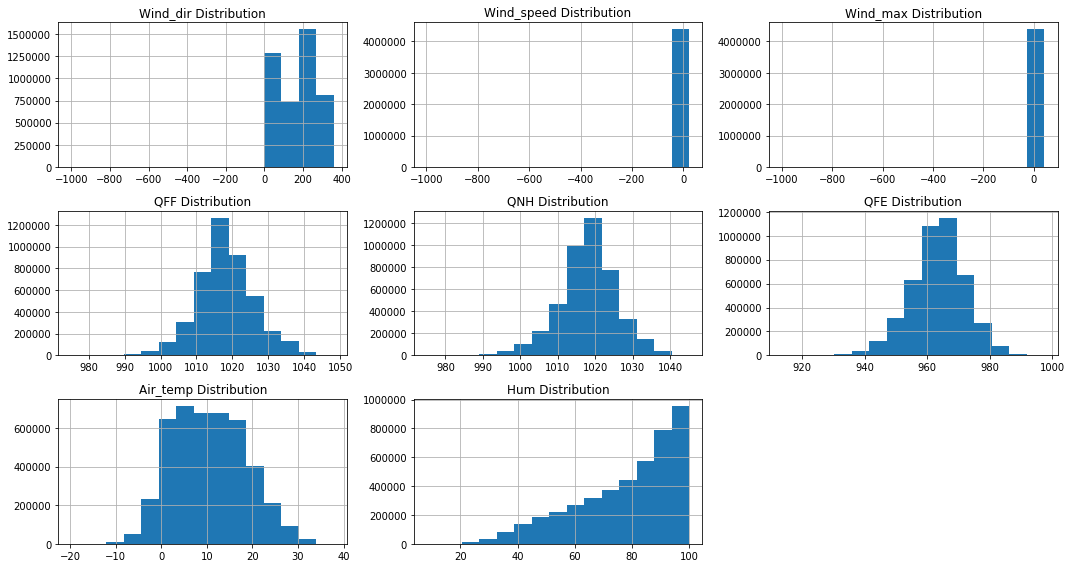

In [101]:
import matplotlib.pyplot as plt

def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure(figsize=(15,8))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=15,ax=ax)
        ax.set_title(var_name+" Distribution")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()


draw_histograms(df, cols_int, 3, 3)

In [130]:
df_interpol = df[['datetime','Station','Wind_dir', 'Wind_speed', 'Wind_max', 'QFF', 'QNH', 'QFE', 'Air_temp', 'Hum']  ]

In [131]:
df_interpol.shape

(4397153, 10)

In [132]:
dh.store_df_as_csv(df_interpol, 'weather_data_for_interpolation.csv')

In [133]:
df.isna().sum()

Station                 0
datetime                0
Wind_dir             9085
Wind_dir_interp      9085
Wind_speed           9026
Wind_speed_interp    9026
Wind_max             9339
Wind_max_interp      9339
QFF                  6304
QFF_interp           6304
QNH                  7781
QNH_interp           7781
QFE                  2610
QFE_interp           2610
Air_temp             6784
Air_temp_interp      6784
Hum                  6365
Hum_interp           6365
Date                    0
Time                    0
Year                    0
Day                     0
Month                   0
Hour                    0
dtype: int64

###  Interpolation performed  with R libraries, Notebook 'R-Kalman_Interpolation.rmd'
#### Load the interpolated data

In [ ]:
df_interpol = dh.load_df_from_csv('weather_data_with_interpolation.csv')

# The wrong columns were passed to the R scripts, so they need to be renamed with suffix 'interp'
df_interpol.rename(columns={'Wind_dir': 'Wind_dir_interp', 'Wind_speed': 'Wind_speed_interp',
                           'Wind_max': 'Wind_max_interp', 'QFF': 'QFF_interp', 
                           'QNH': 'QNH_interp','QFE': 'QFE_interp','Air_temp': 'Air_temp_interp', 
                            'Hum': 'Hum_interp'}, inplace=True)
df_interpol.head()

In [6]:
df_interpol.drop(columns=['X1'], inplace=True)
dh.store_df_as_csv(df_interpol, 'weather_data_with_interpolation.csv')

### Entry point for resuming work (e.g. import interpolated values)

In [4]:
df = dh.load_df_from_csv('weather_combined_stations_with_interp_cols.csv')
df_interpol = dh.load_df_from_csv('weather_data_with_interpolation.csv')

/Users/marco/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [5]:
df.head()

,Station,datetime,Wind_dir,Wind_dir_interp,Wind_speed,Wind_speed_interp,Wind_max,Wind_max_interp,QFF,QFF_interp,...,Air_temp,Air_temp_interp,Hum,Hum_interp,Date,Time,Year,Day,Month,Hour
0,KLO,2014-01-01 00:00:00,138.0,138.0,3.9,3.9,5.6,5.6,1019.4,1019.4,...,-3.0,-3.0,96.1,96.1,2014-01-01,00:00:00,2014,1,1,0
1,KLO,2014-01-01 00:10:00,149.0,149.0,3.3,3.3,5.7,5.7,1019.5,1019.5,...,-3.0,-3.0,95.2,95.2,2014-01-01,00:10:00,2014,1,1,0
2,KLO,2014-01-01 00:20:00,145.0,145.0,3.1,3.1,4.4,4.4,1019.5,1019.5,...,-3.0,-3.0,94.4,94.4,2014-01-01,00:20:00,2014,1,1,0
3,KLO,2014-01-01 00:30:00,127.0,127.0,3.7,3.7,4.6,4.6,1019.5,1019.5,...,-2.9,-2.9,91.7,91.7,2014-01-01,00:30:00,2014,1,1,0
4,KLO,2014-01-01 00:40:00,131.0,131.0,4.1,4.1,5.0,5.0,1019.3,1019.3,...,-2.8,-2.8,90.8,90.8,2014-01-01,00:40:00,2014,1,1,0


In [6]:
df_interpol.head()

,datetime,Station,Wind_dir_interp,Wind_speed_interp,Wind_max_interp,QFF_interp,QNH_interp,QFE_interp,Air_temp_interp,Hum_interp
1,2014-01-01 00:00:00,KLO,138.0,3.9,5.6,1019.4,1016.6,966.1,-3.0,96.1
2,2014-01-01 00:10:00,KLO,149.0,3.3,5.7,1019.5,1016.7,966.2,-3.0,95.2
3,2014-01-01 00:20:00,KLO,145.0,3.1,4.4,1019.5,1016.7,966.2,-3.0,94.4
4,2014-01-01 00:30:00,KLO,127.0,3.7,4.6,1019.5,1016.7,966.2,-2.9,91.7
5,2014-01-01 00:40:00,KLO,131.0,4.1,5.0,1019.3,1016.6,966.1,-2.8,90.8


In [7]:
print(df.shape, df_interpol.shape)

(4397153, 24) (4397153, 10)


In [8]:
df_interpol.isna().sum()

datetime             0
Station              0
Wind_dir_interp      0
Wind_speed_interp    0
Wind_max_interp      0
QFF_interp           0
QNH_interp           0
QFE_interp           0
Air_temp_interp      0
Hum_interp           0
dtype: int64

In [9]:
df.isna().sum()

Station                 0
datetime                0
Wind_dir             9085
Wind_dir_interp      9085
Wind_speed           9026
Wind_speed_interp    9026
Wind_max             9339
Wind_max_interp      9339
QFF                  6304
QFF_interp           6304
QNH                  7781
QNH_interp           7781
QFE                  2610
QFE_interp           2610
Air_temp             6784
Air_temp_interp      6784
Hum                  6365
Hum_interp           6365
Date                    0
Time                    0
Year                    0
Day                     0
Month                   0
Hour                    0
dtype: int64

In [10]:
cols_interp = [c for c in df_interpol.columns if not (c in ['datetime', 'Station'])]
cols_interp

['Wind_dir_interp',
 'Wind_speed_interp',
 'Wind_max_interp',
 'QFF_interp',
 'QNH_interp',
 'QFE_interp',
 'Air_temp_interp',
 'Hum_interp']

In [11]:
df1 = df.copy()

for c in cols_interp:
    df1.loc[:, c] = df_interpol[c]   

In [21]:
df.isna().sum()

Station                 0
datetime                0
Wind_dir             9085
Wind_dir_interp         0
Wind_speed           9026
Wind_speed_interp       0
Wind_max             9339
Wind_max_interp         0
QFF                  6304
QFF_interp              0
QNH                  7781
QNH_interp              0
QFE                  2610
QFE_interp              0
Air_temp             6784
Air_temp_interp         0
Hum                  6365
Hum_interp              0
Date                    0
Time                    0
Year                    0
Day                     0
Month                   0
Hour                    0
dtype: int64

In [26]:
df[df.Wind_dir.isna()]

,Station,datetime,Wind_dir,Wind_dir_interp,Wind_speed,Wind_speed_interp,Wind_max,Wind_max_interp,QFF,QFF_interp,...,Air_temp,Air_temp_interp,Hum,Hum_interp,Date,Time,Year,Day,Month,Hour
76689,KLO,2015-06-17 13:30:00,NaN,194.034248,NaN,1.326894,NaN,3.599887,1020.1,1020.100000,...,21.2,21.200000,50.1,50.100000,2015-06-17,13:30:00,2015,17,6,13
76690,KLO,2015-06-17 13:40:00,NaN,194.366647,NaN,1.332924,NaN,3.599123,1020.1,1020.100000,...,21.3,21.300000,49.9,49.900000,2015-06-17,13:40:00,2015,17,6,13
76691,KLO,2015-06-17 13:50:00,NaN,194.699045,NaN,1.338954,NaN,3.598359,1020.0,1020.000000,...,21.4,21.400000,49.8,49.800000,2015-06-17,13:50:00,2015,17,6,13
76692,KLO,2015-06-17 14:00:00,NaN,195.031444,NaN,1.344985,NaN,3.597595,1020.0,1020.000000,...,21.4,21.400000,49.7,49.700000,2015-06-17,14:00:00,2015,17,6,14
76693,KLO,2015-06-17 14:10:00,NaN,195.363842,NaN,1.351015,NaN,3.596830,1020.0,1020.000000,...,21.4,21.400000,49.6,49.600000,2015-06-17,14:10:00,2015,17,6,14
76694,KLO,2015-06-17 14:20:00,NaN,195.696241,NaN,1.357045,NaN,3.596066,1020.0,1020.000000,...,21.4,21.400000,49.6,49.600000,2015-06-17,14:20:00,2015,17,6,14
76695,KLO,2015-06-17 14:30:00,NaN,196.028639,NaN,1.363075,NaN,3.595302,1019.9,1019.900000,...,21.4,21.400000,49.6,49.600000,2015-06-17,14:30:00,2015,17,6,14
76696,KLO,2015-06-17 14:40:00,NaN,196.361038,NaN,1.369105,NaN,3.594538,1019.9,1019.900000,...,21.4,21.400000,49.5,49.500000,2015-06-17,14:40:00,2015,17,6,14
76697,KLO,2015-06-17 14:50:00,NaN,196.693436,NaN,1.375135,NaN,3.593773,1019.9,1019.900000,...,21.4,21.400000,49.5,49.500000,2015-06-17,14:50:00,2015,17,6,14
76698,KLO,2015-06-17 15:00:00,NaN,197.025835,NaN,1.381165,NaN,3.593009,1019.9,1019.900000,...,21.4,21.400000,49.5,49.500000,2015-06-17,15:00:00,2015,17,6,15


In [13]:
df1.Wind_dir_interp = np.where((df1.Wind_dir != df1.Wind_dir_interp) & df1.Wind_dir.notnull(), df1.Wind_dir, df1.Wind_dir_interp)
df1.Wind_speed_interp = np.where((df1.Wind_speed != df1.Wind_speed_interp) & df1.Wind_speed.notnull(), df1.Wind_speed, df1.Wind_speed_interp)
df1.Wind_max_interp = np.where((df1.Wind_max != df1.Wind_max_interp) & df1.Wind_max.notnull(), df1.Wind_max, df1.Wind_max_interp)
df1.QFF_interp = np.where((df1.QFF != df1.QFF_interp) & df1.QFF.notnull(), df1.QFF, df1.QFF_interp)
df1.QNH_interp = np.where((df1.QNH != df1.QNH_interp) & df1.QNH.notnull(), df1.QNH, df1.QNH_interp)
df1.QFE_interp = np.where((df1.QFE != df1.QNH_interp) & df1.QFE.notnull(), df1.QFE, df1.QFE_interp)
df1.Air_temp_interp = np.where((df1.Air_temp != df1.Air_temp_interp) & df1.Air_temp.notnull(), df1.Air_temp, df1.Air_temp_interp)
df1.Hum_interp = np.where((df1.Hum != df1.Hum_interp) & df1.Hum.notnull(), df1.Hum, df1.Hum_interp)

In [14]:
df1[cols_interp].isna().sum()[df1[cols_interp].isna().sum() > 0]

Series([], dtype: int64)

In [15]:
df1.head()

,Station,datetime,Wind_dir,Wind_dir_interp,Wind_speed,Wind_speed_interp,Wind_max,Wind_max_interp,QFF,QFF_interp,...,Air_temp,Air_temp_interp,Hum,Hum_interp,Date,Time,Year,Day,Month,Hour
0,KLO,2014-01-01 00:00:00,138.0,138.0,3.9,3.9,5.6,5.6,1019.4,1019.4,...,-3.0,-3.0,96.1,96.1,2014-01-01,00:00:00,2014,1,1,0
1,KLO,2014-01-01 00:10:00,149.0,149.0,3.3,3.3,5.7,5.7,1019.5,1019.5,...,-3.0,-3.0,95.2,95.2,2014-01-01,00:10:00,2014,1,1,0
2,KLO,2014-01-01 00:20:00,145.0,145.0,3.1,3.1,4.4,4.4,1019.5,1019.5,...,-3.0,-3.0,94.4,94.4,2014-01-01,00:20:00,2014,1,1,0
3,KLO,2014-01-01 00:30:00,127.0,127.0,3.7,3.7,4.6,4.6,1019.5,1019.5,...,-2.9,-2.9,91.7,91.7,2014-01-01,00:30:00,2014,1,1,0
4,KLO,2014-01-01 00:40:00,131.0,131.0,4.1,4.1,5.0,5.0,1019.3,1019.3,...,-2.8,-2.8,90.8,90.8,2014-01-01,00:40:00,2014,1,1,0


In [35]:
df1.tail()

,Station,datetime,Wind_dir,Wind_dir_interp,Wind_speed,Wind_speed_interp,Wind_max,Wind_max_interp,QFF,QFF_interp,QNH,QNH_interp,QFE,QFE_interp,Air_temp,Air_temp_interp,Hum,Hum_interp,Date,Time,Year,Day,Month,Hour
4397148,WYN,2018-12-30 23:20:00,359.000,359.000,1.100,1.100,1.800,1.800,"1,036.900","1,036.900","1,034.900","1,034.900",984.200,984.200,2.400,2.400,95.100,95.100,2018-12-30,23:20:00,2018,30,12,23
4397149,WYN,2018-12-30 23:30:00,45.000,45.000,0.700,0.700,1.400,1.400,"1,036.900","1,036.900","1,034.900","1,034.900",984.200,984.200,2.300,2.300,96.000,96.000,2018-12-30,23:30:00,2018,30,12,23
4397150,WYN,2018-12-30 23:40:00,60.000,60.000,1.600,1.600,2.000,2.000,"1,036.800","1,036.800","1,034.800","1,034.800",984.100,984.100,2.400,2.400,96.300,96.300,2018-12-30,23:40:00,2018,30,12,23
4397151,WYN,2018-12-30 23:50:00,51.000,51.000,1.400,1.400,1.700,1.700,"1,036.700","1,036.700","1,034.700","1,034.700",984.000,984.000,2.200,2.200,96.300,96.300,2018-12-30,23:50:00,2018,30,12,23
4397152,WYN,2018-12-31 00:00:00,50.000,50.000,1.200,1.200,1.600,1.600,"1,036.800","1,036.800","1,034.800","1,034.800",984.100,984.100,2.300,2.300,96.000,96.000,2018-12-31,00:00:00,2018,31,12,0


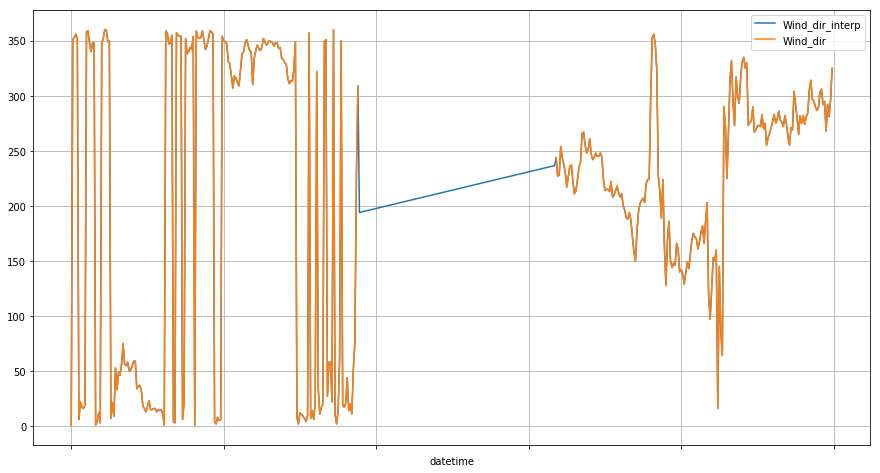

In [30]:
df[76500:77000].plot(x='datetime', y=['Wind_dir_interp', 'Wind_dir'], figsize=(15,8), grid=True)

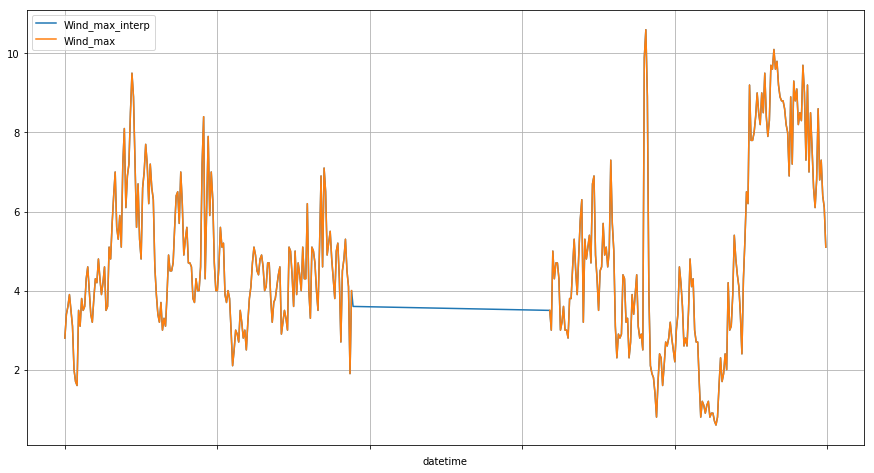

In [31]:
df[76500:77000].plot(x='datetime', y=['Wind_max_interp', 'Wind_max'], figsize=(15,8), grid=True)

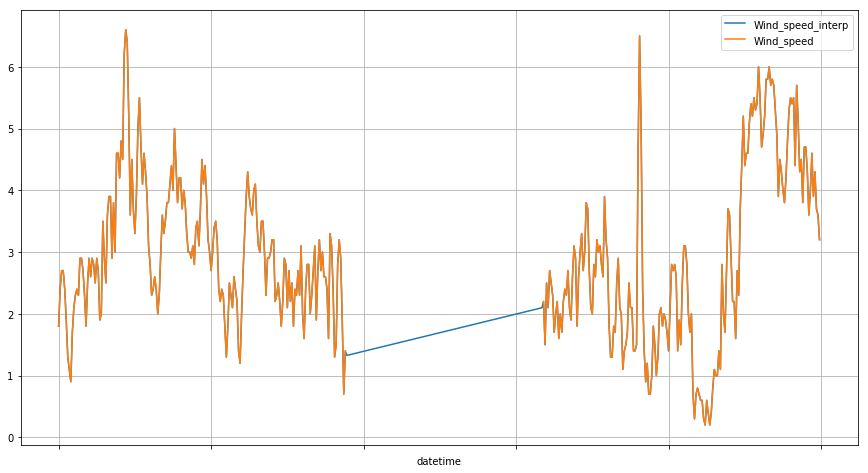

In [32]:
df[76500:77000].plot(x='datetime', y=['Wind_speed_interp', 'Wind_speed'], figsize=(15,8), grid=True)

In [34]:
df[df.Hum.isna()]

,Station,datetime,Wind_dir,Wind_dir_interp,Wind_speed,Wind_speed_interp,Wind_max,Wind_max_interp,QFF,QFF_interp,...,Air_temp,Air_temp_interp,Hum,Hum_interp,Date,Time,Year,Day,Month,Hour
844102,TAE,2015-01-22 19:10:00,NaN,308.297327,NaN,0.605291,NaN,0.946574,NaN,1017.838378,...,NaN,-0.492774,NaN,93.869921,2015-01-22,19:10:00,2015,22,1,19
844103,TAE,2015-01-22 19:20:00,NaN,307.555635,NaN,0.606046,NaN,0.949083,NaN,1017.876757,...,NaN,-0.491183,NaN,93.862251,2015-01-22,19:20:00,2015,22,1,19
844104,TAE,2015-01-22 19:30:00,NaN,306.813944,NaN,0.606801,NaN,0.951593,NaN,1017.915135,...,NaN,-0.489592,NaN,93.854581,2015-01-22,19:30:00,2015,22,1,19
844105,TAE,2015-01-22 19:40:00,NaN,306.072252,NaN,0.607556,NaN,0.954102,NaN,1017.953514,...,NaN,-0.488002,NaN,93.846911,2015-01-22,19:40:00,2015,22,1,19
844106,TAE,2015-01-22 19:50:00,NaN,305.330560,NaN,0.608311,NaN,0.956612,NaN,1017.991892,...,NaN,-0.486411,NaN,93.839241,2015-01-22,19:50:00,2015,22,1,19
844107,TAE,2015-01-22 20:00:00,NaN,304.588869,NaN,0.609066,NaN,0.959121,NaN,1018.030270,...,NaN,-0.484820,NaN,93.831571,2015-01-22,20:00:00,2015,22,1,20
844108,TAE,2015-01-22 20:10:00,NaN,303.847177,NaN,0.609821,NaN,0.961631,NaN,1018.068649,...,NaN,-0.483229,NaN,93.823901,2015-01-22,20:10:00,2015,22,1,20
844109,TAE,2015-01-22 20:20:00,NaN,303.105485,NaN,0.610576,NaN,0.964140,NaN,1018.107027,...,NaN,-0.481638,NaN,93.816231,2015-01-22,20:20:00,2015,22,1,20
844110,TAE,2015-01-22 20:30:00,NaN,302.363794,NaN,0.611331,NaN,0.966650,NaN,1018.145405,...,NaN,-0.480047,NaN,93.808561,2015-01-22,20:30:00,2015,22,1,20
844111,TAE,2015-01-22 20:40:00,NaN,301.622102,NaN,0.612086,NaN,0.969159,NaN,1018.183784,...,NaN,-0.478456,NaN,93.800891,2015-01-22,20:40:00,2015,22,1,20


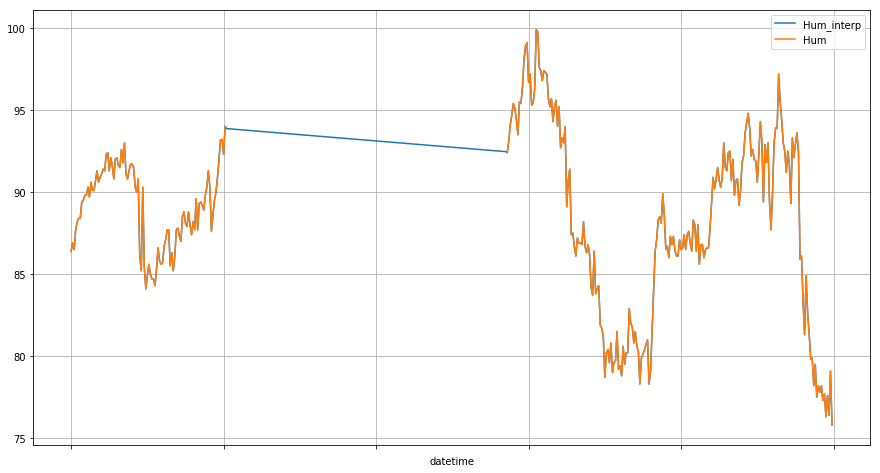

In [36]:
df[844000:844500].plot(x='datetime', y=['Hum_interp', 'Hum'], figsize=(15,8), grid=True)

In [37]:
df[df.Air_temp.isna()]

,Station,datetime,Wind_dir,Wind_dir_interp,Wind_speed,Wind_speed_interp,Wind_max,Wind_max_interp,QFF,QFF_interp,...,Air_temp,Air_temp_interp,Hum,Hum_interp,Date,Time,Year,Day,Month,Hour
844102,TAE,2015-01-22 19:10:00,NaN,308.297327,NaN,0.605291,NaN,0.946574,NaN,1017.838378,...,NaN,-0.492774,NaN,93.869921,2015-01-22,19:10:00,2015,22,1,19
844103,TAE,2015-01-22 19:20:00,NaN,307.555635,NaN,0.606046,NaN,0.949083,NaN,1017.876757,...,NaN,-0.491183,NaN,93.862251,2015-01-22,19:20:00,2015,22,1,19
844104,TAE,2015-01-22 19:30:00,NaN,306.813944,NaN,0.606801,NaN,0.951593,NaN,1017.915135,...,NaN,-0.489592,NaN,93.854581,2015-01-22,19:30:00,2015,22,1,19
844105,TAE,2015-01-22 19:40:00,NaN,306.072252,NaN,0.607556,NaN,0.954102,NaN,1017.953514,...,NaN,-0.488002,NaN,93.846911,2015-01-22,19:40:00,2015,22,1,19
844106,TAE,2015-01-22 19:50:00,NaN,305.330560,NaN,0.608311,NaN,0.956612,NaN,1017.991892,...,NaN,-0.486411,NaN,93.839241,2015-01-22,19:50:00,2015,22,1,19
844107,TAE,2015-01-22 20:00:00,NaN,304.588869,NaN,0.609066,NaN,0.959121,NaN,1018.030270,...,NaN,-0.484820,NaN,93.831571,2015-01-22,20:00:00,2015,22,1,20
844108,TAE,2015-01-22 20:10:00,NaN,303.847177,NaN,0.609821,NaN,0.961631,NaN,1018.068649,...,NaN,-0.483229,NaN,93.823901,2015-01-22,20:10:00,2015,22,1,20
844109,TAE,2015-01-22 20:20:00,NaN,303.105485,NaN,0.610576,NaN,0.964140,NaN,1018.107027,...,NaN,-0.481638,NaN,93.816231,2015-01-22,20:20:00,2015,22,1,20
844110,TAE,2015-01-22 20:30:00,NaN,302.363794,NaN,0.611331,NaN,0.966650,NaN,1018.145405,...,NaN,-0.480047,NaN,93.808561,2015-01-22,20:30:00,2015,22,1,20
844111,TAE,2015-01-22 20:40:00,NaN,301.622102,NaN,0.612086,NaN,0.969159,NaN,1018.183784,...,NaN,-0.478456,NaN,93.800891,2015-01-22,20:40:00,2015,22,1,20


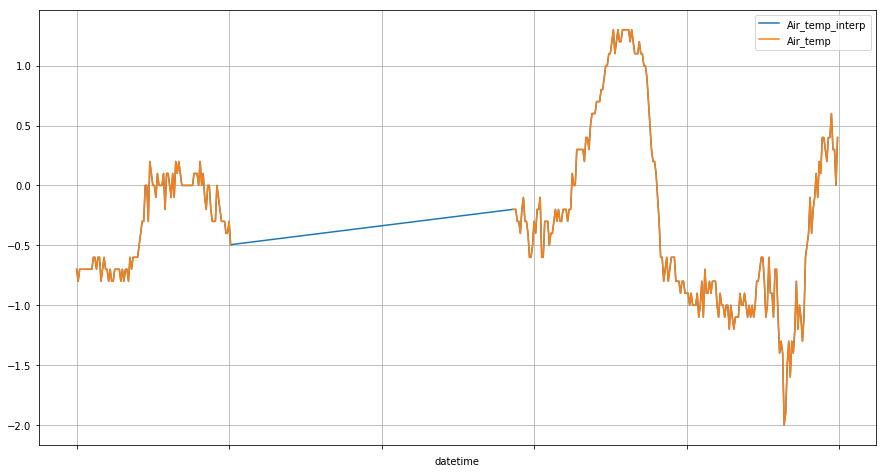

In [38]:
df[844000:844500].plot(x='datetime', y=['Air_temp_interp', 'Air_temp'], figsize=(15,8), grid=True)

### Save state of dataset

In [36]:
dh.store_df_as_csv(df1, 'weather_combined_adjusted_interp_cols.csv')

In [17]:
df = dh.load_df_from_csv('weather_combined_adjusted_interp_cols.csv')

## Create new station features for master data frame
- Group features by station
- For each station create a group of features, feature name prefixed by station abbreviation
- Save

In [76]:
# create a dictionary to subset dataframe according to station name (key = station, value = df['station'])
df_dict = dict()
for station in stations:
    df_dict[station] = df[df['Station']==station]

# check the code works:
print(df_dict['OBR'].shape)
df_dict['OBR'].head()

(192337, 24)


,Station,datetime,Wind_dir,Wind_dir_interp,Wind_speed,Wind_speed_interp,Wind_max,Wind_max_interp,QFF,QFF_interp,QNH,QNH_interp,QFE,QFE_interp,Air_temp,Air_temp_interp,Hum,Hum_interp,Date,Time,Year,Day,Month,Hour
2890811,OBR,2015-05-05 08:00:00,202.000,202.000,10.100,10.100,16.500,16.500,"1,004.300","1,004.300","1,006.400","1,006.400",958.400,958.400,22.800,22.800,42.600,42.600,2015-05-05,08:00:00,2015,5,5,8
2890812,OBR,2015-05-05 08:10:00,192.000,192.000,9.400,9.400,15.700,15.700,"1,004.300","1,004.300","1,006.400","1,006.400",958.400,958.400,23.000,23.000,41.700,41.700,2015-05-05,08:10:00,2015,5,5,8
2890813,OBR,2015-05-05 08:20:00,195.000,195.000,9.700,9.700,15.800,15.800,"1,004.500","1,004.500","1,006.600","1,006.600",958.600,958.600,23.000,23.000,42.100,42.100,2015-05-05,08:20:00,2015,5,5,8
2890814,OBR,2015-05-05 08:30:00,190.000,190.000,7.600,7.600,11.400,11.400,"1,004.700","1,004.700","1,006.800","1,006.800",958.800,958.800,22.900,22.900,43.800,43.800,2015-05-05,08:30:00,2015,5,5,8
2890815,OBR,2015-05-05 08:40:00,192.000,192.000,7.800,7.800,11.600,11.600,"1,004.900","1,004.900","1,006.900","1,006.900",958.900,958.900,22.500,22.500,44.800,44.800,2015-05-05,08:40:00,2015,5,5,8


In [77]:
# features we want to use in the model
original_features = ['datetime','Wind_dir', 'Wind_dir_interp', 'Wind_speed', 'Wind_speed_interp', 'Wind_max', 'Wind_max_interp', 'QFF', 'QFF_interp','QNH','QNH_interp','QFE','QFE_interp','Air_temp', 'Air_temp_interp','Hum', 'Hum_interp']

# create a dictionary: key = station, value = list of new column names (excluding KLO)
station_col_names = dict()

#Station	datetime Date	Time	Year	Day	Month	Hour

for station in stations:
    stationfeatures = ['datetime']
    for feature in features:
        if feature != 'datetime':
            stationfeatures.append(station+'_'+feature)
    station_col_names[station] = stationfeatures

# rename the columns in each dataframe to the new name
old_names = features 
for station in stations:
    new_names = station_col_names[station]
    #print(new_names)
    temp = df_dict[station].rename(columns=dict(zip(original_features, new_names)), inplace=False)
    #print(temp.shape)
    #print(temp.columns)
    temp = temp[new_names]
    df_dict[station] = temp

df_dict['OBR'].head()

,datetime,OBR_Wind_dir,OBR_Wind_dir_interp,OBR_Wind_speed,OBR_Wind_speed_interp,OBR_Wind_max,OBR_Wind_max_interp,OBR_QFF,OBR_QFF_interp,OBR_QNH,OBR_QNH_interp,OBR_QFE,OBR_QFE_interp,OBR_Air_temp,OBR_Air_temp_interp,OBR_Hum,OBR_Hum_interp
2890811,2015-05-05 08:00:00,202.000,202.000,10.100,10.100,16.500,16.500,"1,004.300","1,004.300","1,006.400","1,006.400",958.400,958.400,22.800,22.800,42.600,42.600
2890812,2015-05-05 08:10:00,192.000,192.000,9.400,9.400,15.700,15.700,"1,004.300","1,004.300","1,006.400","1,006.400",958.400,958.400,23.000,23.000,41.700,41.700
2890813,2015-05-05 08:20:00,195.000,195.000,9.700,9.700,15.800,15.800,"1,004.500","1,004.500","1,006.600","1,006.600",958.600,958.600,23.000,23.000,42.100,42.100
2890814,2015-05-05 08:30:00,190.000,190.000,7.600,7.600,11.400,11.400,"1,004.700","1,004.700","1,006.800","1,006.800",958.800,958.800,22.900,22.900,43.800,43.800
2890815,2015-05-05 08:40:00,192.000,192.000,7.800,7.800,11.600,11.600,"1,004.900","1,004.900","1,006.900","1,006.900",958.900,958.900,22.500,22.500,44.800,44.800


### Order the features
- Features from Kloten (KLO) will follow datetime
- The remaining features will be ordered alphabetically

In [53]:
 # Left merge the dataframes according to datetime column with KLO left

# create the master dataframe which has KLO and all the other station's data joined as new features
master_df = df_dict['KLO']
for station in stations:
    if station != 'KLO':
        master_df = pd.merge(master_df, df_dict[station],  how='left', left_on=['datetime'], right_on = ['datetime'])

# check the code works:
master_df.shape

(262801, 273)

In [54]:
master_df.head()

,datetime,KLO_Wind_dir,KLO_Wind_dir_interp,KLO_Wind_speed,KLO_Wind_speed_interp,KLO_Wind_max,KLO_Wind_max_interp,KLO_QFF,KLO_QFF_interp,KLO_QNH,KLO_QNH_interp,KLO_QFE,KLO_QFE_interp,KLO_Air_temp,KLO_Air_temp_interp,KLO_Hum,KLO_Hum_interp,REH_Wind_dir,REH_Wind_dir_interp,REH_Wind_speed,REH_Wind_speed_interp,REH_Wind_max,REH_Wind_max_interp,REH_QFF,REH_QFF_interp,REH_QNH,REH_QNH_interp,REH_QFE,REH_QFE_interp,REH_Air_temp,REH_Air_temp_interp,REH_Hum,REH_Hum_interp,SMA_Wind_dir,SMA_Wind_dir_interp,SMA_Wind_speed,SMA_Wind_speed_interp,SMA_Wind_max,SMA_Wind_max_interp,SMA_QFF,SMA_QFF_interp,SMA_QNH,SMA_QNH_interp,SMA_QFE,SMA_QFE_interp,SMA_Air_temp,SMA_Air_temp_interp,SMA_Hum,SMA_Hum_interp,TAE_Wind_dir,TAE_Wind_dir_interp,TAE_Wind_speed,TAE_Wind_speed_interp,TAE_Wind_max,TAE_Wind_max_interp,TAE_QFF,TAE_QFF_interp,TAE_QNH,TAE_QNH_interp,TAE_QFE,TAE_QFE_interp,TAE_Air_temp,TAE_Air_temp_interp,TAE_Hum,TAE_Hum_interp,WAE_Wind_dir,WAE_Wind_dir_interp,WAE_Wind_speed,WAE_Wind_speed_interp,WAE_Wind_max,WAE_Wind_max_interp,WAE_QFF,WAE_QFF_interp,WAE_QNH,WAE_QNH_interp,WAE_QFE,WAE_QFE_interp,WAE_Air_temp,WAE_Air_temp_interp,WAE_Hum,WAE_Hum_interp,BIZ_Wind_dir,BIZ_Wind_dir_interp,BIZ_Wind_speed,BIZ_Wind_speed_interp,BIZ_Wind_max,BIZ_Wind_max_interp,BIZ_QFF,BIZ_QFF_interp,BIZ_QNH,BIZ_QNH_interp,BIZ_QFE,BIZ_QFE_interp,BIZ_Air_temp,BIZ_Air_temp_interp,BIZ_Hum,BIZ_Hum_interp,BUS_Wind_dir,BUS_Wind_dir_interp,BUS_Wind_speed,BUS_Wind_speed_interp,BUS_Wind_max,BUS_Wind_max_interp,BUS_QFF,BUS_QFF_interp,BUS_QNH,BUS_QNH_interp,BUS_QFE,BUS_QFE_interp,BUS_Air_temp,BUS_Air_temp_interp,BUS_Hum,BUS_Hum_interp,GUT_Wind_dir,GUT_Wind_dir_interp,GUT_Wind_speed,GUT_Wind_speed_interp,GUT_Wind_max,GUT_Wind_max_interp,GUT_QFF,GUT_QFF_interp,GUT_QNH,GUT_QNH_interp,GUT_QFE,GUT_QFE_interp,GUT_Air_temp,GUT_Air_temp_interp,GUT_Hum,GUT_Hum_interp,KOP_Wind_dir,KOP_Wind_dir_interp,KOP_Wind_speed,KOP_Wind_speed_interp,KOP_Wind_max,KOP_Wind_max_interp,KOP_QFF,KOP_QFF_interp,KOP_QNH,KOP_QNH_interp,KOP_QFE,KOP_QFE_interp,KOP_Air_temp,KOP_Air_temp_interp,KOP_Hum,KOP_Hum_interp,MOA_Wind_dir,MOA_Wind_dir_interp,MOA_Wind_speed,MOA_Wind_speed_interp,MOA_Wind_max,MOA_Wind_max_interp,MOA_QFF,MOA_QFF_interp,MOA_QNH,MOA_QNH_interp,MOA_QFE,MOA_QFE_interp,MOA_Air_temp,MOA_Air_temp_interp,MOA_Hum,MOA_Hum_interp,MUB_Wind_dir,MUB_Wind_dir_interp,MUB_Wind_speed,MUB_Wind_speed_interp,MUB_Wind_max,MUB_Wind_max_interp,MUB_QFF,MUB_QFF_interp,MUB_QNH,MUB_QNH_interp,MUB_QFE,MUB_QFE_interp,MUB_Air_temp,MUB_Air_temp_interp,MUB_Hum,MUB_Hum_interp,OBR_Wind_dir,OBR_Wind_dir_interp,OBR_Wind_speed,OBR_Wind_speed_interp,OBR_Wind_max,OBR_Wind_max_interp,OBR_QFF,OBR_QFF_interp,OBR_QNH,OBR_QNH_interp,OBR_QFE,OBR_QFE_interp,OBR_Air_temp,OBR_Air_temp_interp,OBR_Hum,OBR_Hum_interp,PAY_Wind_dir,PAY_Wind_dir_interp,PAY_Wind_speed,PAY_Wind_speed_interp,PAY_Wind_max,PAY_Wind_max_interp,PAY_QFF,PAY_QFF_interp,PAY_QNH,PAY_QNH_interp,PAY_QFE,PAY_QFE_interp,PAY_Air_temp,PAY_Air_temp_interp,PAY_Hum,PAY_Hum_interp,PUY_Wind_dir,PUY_Wind_dir_interp,PUY_Wind_speed,PUY_Wind_speed_interp,PUY_Wind_max,PUY_Wind_max_interp,PUY_QFF,PUY_QFF_interp,PUY_QNH,PUY_QNH_interp,PUY_QFE,PUY_QFE_interp,PUY_Air_temp,PUY_Air_temp_interp,PUY_Hum,PUY_Hum_interp,SHA_Wind_dir,SHA_Wind_dir_interp,SHA_Wind_speed,SHA_Wind_speed_interp,SHA_Wind_max,SHA_Wind_max_interp,SHA_QFF,SHA_QFF_interp,SHA_QNH,SHA_QNH_interp,SHA_QFE,SHA_QFE_interp,SHA_Air_temp,SHA_Air_temp_interp,SHA_Hum,SHA_Hum_interp,VAD_Wind_dir,VAD_Wind_dir_interp,VAD_Wind_speed,VAD_Wind_speed_interp,VAD_Wind_max,VAD_Wind_max_interp,VAD_QFF,VAD_QFF_interp,VAD_QNH,VAD_QNH_interp,VAD_QFE,VAD_QFE_interp,VAD_Air_temp,VAD_Air_temp_interp,VAD_Hum,VAD_Hum_interp,WYN_Wind_dir,WYN_Wind_dir_interp,WYN_Wind_speed,WYN_Wind_speed_interp,WYN_Wind_max,WYN_Wind_max_interp,WYN_QFF,WYN_QFF_interp,WYN_QNH,WYN_QNH_interp,WYN_QFE,WYN_QFE_interp,WYN_Air_temp,WYN_Air_temp_interp,WYN_Hum,WYN_Hum_interp
0,2014-01-01 00:00:00,138.000,138.000,3.900,3.900,5.600,5.600,"1,019.400","1,019.400","1,016.600","1,016.600",966.

In [70]:
df_dict['OBR'].isna().sum()

datetime                 0
OBR_Wind_dir             0
OBR_Wind_dir_interp      0
OBR_Wind_speed           0
OBR_Wind_speed_interp    0
OBR_Wind_max             0
OBR_Wind_max_interp      0
OBR_QFF                  0
OBR_QFF_interp           0
OBR_QNH                  0
OBR_QNH_interp           0
OBR_QFE                  0
OBR_QFE_interp           0
OBR_Air_temp             0
OBR_Air_temp_interp      0
OBR_Hum                  0
OBR_Hum_interp           0
dtype: int64

### Save state of dataset

In [57]:
dh.store_df_as_csv_compressed(master_df, 'master_weather_dataset.csv.zip')

### Oberriet (OBR) is a recent station with a limited set of data (since May 2015)
#### This leads to the presence of disturbing NaNs: drop relative data from dataset

In [59]:
df_master = dh.load_df_from_csv( 'master_weather_dataset.csv.zip')
df_master.head()

,datetime,KLO_Wind_dir,KLO_Wind_dir_interp,KLO_Wind_speed,KLO_Wind_speed_interp,KLO_Wind_max,KLO_Wind_max_interp,KLO_QFF,KLO_QFF_interp,KLO_QNH,KLO_QNH_interp,KLO_QFE,KLO_QFE_interp,KLO_Air_temp,KLO_Air_temp_interp,KLO_Hum,KLO_Hum_interp,REH_Wind_dir,REH_Wind_dir_interp,REH_Wind_speed,REH_Wind_speed_interp,REH_Wind_max,REH_Wind_max_interp,REH_QFF,REH_QFF_interp,REH_QNH,REH_QNH_interp,REH_QFE,REH_QFE_interp,REH_Air_temp,REH_Air_temp_interp,REH_Hum,REH_Hum_interp,SMA_Wind_dir,SMA_Wind_dir_interp,SMA_Wind_speed,SMA_Wind_speed_interp,SMA_Wind_max,SMA_Wind_max_interp,SMA_QFF,SMA_QFF_interp,SMA_QNH,SMA_QNH_interp,SMA_QFE,SMA_QFE_interp,SMA_Air_temp,SMA_Air_temp_interp,SMA_Hum,SMA_Hum_interp,TAE_Wind_dir,TAE_Wind_dir_interp,TAE_Wind_speed,TAE_Wind_speed_interp,TAE_Wind_max,TAE_Wind_max_interp,TAE_QFF,TAE_QFF_interp,TAE_QNH,TAE_QNH_interp,TAE_QFE,TAE_QFE_interp,TAE_Air_temp,TAE_Air_temp_interp,TAE_Hum,TAE_Hum_interp,WAE_Wind_dir,WAE_Wind_dir_interp,WAE_Wind_speed,WAE_Wind_speed_interp,WAE_Wind_max,WAE_Wind_max_interp,WAE_QFF,WAE_QFF_interp,WAE_QNH,WAE_QNH_interp,WAE_QFE,WAE_QFE_interp,WAE_Air_temp,WAE_Air_temp_interp,WAE_Hum,WAE_Hum_interp,BIZ_Wind_dir,BIZ_Wind_dir_interp,BIZ_Wind_speed,BIZ_Wind_speed_interp,BIZ_Wind_max,BIZ_Wind_max_interp,BIZ_QFF,BIZ_QFF_interp,BIZ_QNH,BIZ_QNH_interp,BIZ_QFE,BIZ_QFE_interp,BIZ_Air_temp,BIZ_Air_temp_interp,BIZ_Hum,BIZ_Hum_interp,BUS_Wind_dir,BUS_Wind_dir_interp,BUS_Wind_speed,BUS_Wind_speed_interp,BUS_Wind_max,BUS_Wind_max_interp,BUS_QFF,BUS_QFF_interp,BUS_QNH,BUS_QNH_interp,BUS_QFE,BUS_QFE_interp,BUS_Air_temp,BUS_Air_temp_interp,BUS_Hum,BUS_Hum_interp,GUT_Wind_dir,GUT_Wind_dir_interp,GUT_Wind_speed,GUT_Wind_speed_interp,GUT_Wind_max,GUT_Wind_max_interp,GUT_QFF,GUT_QFF_interp,GUT_QNH,GUT_QNH_interp,GUT_QFE,GUT_QFE_interp,GUT_Air_temp,GUT_Air_temp_interp,GUT_Hum,GUT_Hum_interp,KOP_Wind_dir,KOP_Wind_dir_interp,KOP_Wind_speed,KOP_Wind_speed_interp,KOP_Wind_max,KOP_Wind_max_interp,KOP_QFF,KOP_QFF_interp,KOP_QNH,KOP_QNH_interp,KOP_QFE,KOP_QFE_interp,KOP_Air_temp,KOP_Air_temp_interp,KOP_Hum,KOP_Hum_interp,MOA_Wind_dir,MOA_Wind_dir_interp,MOA_Wind_speed,MOA_Wind_speed_interp,MOA_Wind_max,MOA_Wind_max_interp,MOA_QFF,MOA_QFF_interp,MOA_QNH,MOA_QNH_interp,MOA_QFE,MOA_QFE_interp,MOA_Air_temp,MOA_Air_temp_interp,MOA_Hum,MOA_Hum_interp,MUB_Wind_dir,MUB_Wind_dir_interp,MUB_Wind_speed,MUB_Wind_speed_interp,MUB_Wind_max,MUB_Wind_max_interp,MUB_QFF,MUB_QFF_interp,MUB_QNH,MUB_QNH_interp,MUB_QFE,MUB_QFE_interp,MUB_Air_temp,MUB_Air_temp_interp,MUB_Hum,MUB_Hum_interp,OBR_Wind_dir,OBR_Wind_dir_interp,OBR_Wind_speed,OBR_Wind_speed_interp,OBR_Wind_max,OBR_Wind_max_interp,OBR_QFF,OBR_QFF_interp,OBR_QNH,OBR_QNH_interp,OBR_QFE,OBR_QFE_interp,OBR_Air_temp,OBR_Air_temp_interp,OBR_Hum,OBR_Hum_interp,PAY_Wind_dir,PAY_Wind_dir_interp,PAY_Wind_speed,PAY_Wind_speed_interp,PAY_Wind_max,PAY_Wind_max_interp,PAY_QFF,PAY_QFF_interp,PAY_QNH,PAY_QNH_interp,PAY_QFE,PAY_QFE_interp,PAY_Air_temp,PAY_Air_temp_interp,PAY_Hum,PAY_Hum_interp,PUY_Wind_dir,PUY_Wind_dir_interp,PUY_Wind_speed,PUY_Wind_speed_interp,PUY_Wind_max,PUY_Wind_max_interp,PUY_QFF,PUY_QFF_interp,PUY_QNH,PUY_QNH_interp,PUY_QFE,PUY_QFE_interp,PUY_Air_temp,PUY_Air_temp_interp,PUY_Hum,PUY_Hum_interp,SHA_Wind_dir,SHA_Wind_dir_interp,SHA_Wind_speed,SHA_Wind_speed_interp,SHA_Wind_max,SHA_Wind_max_interp,SHA_QFF,SHA_QFF_interp,SHA_QNH,SHA_QNH_interp,SHA_QFE,SHA_QFE_interp,SHA_Air_temp,SHA_Air_temp_interp,SHA_Hum,SHA_Hum_interp,VAD_Wind_dir,VAD_Wind_dir_interp,VAD_Wind_speed,VAD_Wind_speed_interp,VAD_Wind_max,VAD_Wind_max_interp,VAD_QFF,VAD_QFF_interp,VAD_QNH,VAD_QNH_interp,VAD_QFE,VAD_QFE_interp,VAD_Air_temp,VAD_Air_temp_interp,VAD_Hum,VAD_Hum_interp,WYN_Wind_dir,WYN_Wind_dir_interp,WYN_Wind_speed,WYN_Wind_speed_interp,WYN_Wind_max,WYN_Wind_max_interp,WYN_QFF,WYN_QFF_interp,WYN_QNH,WYN_QNH_interp,WYN_QFE,WYN_QFE_interp,WYN_Air_temp,WYN_Air_temp_interp,WYN_Hum,WYN_Hum_interp
0,2014-01-01 00:00:00,138.000,138.000,3.900,3.900,5.600,5.600,"1,019.400","1,019.400","1,016.600","1,016.600",966.

In [79]:
df_master[['datetime','OBR_Wind_dir_interp', 'OBR_Wind_speed_interp', 'OBR_Wind_max_interp', 'OBR_QFF_interp', 'OBR_QNH_interp', 'OBR_QFE_interp', 'OBR_Air_temp_interp', 'OBR_Hum_interp']]

,datetime,OBR_Wind_dir_interp,OBR_Wind_speed_interp,OBR_Wind_max_interp,OBR_QFF_interp,OBR_QNH_interp,OBR_QFE_interp,OBR_Air_temp_interp,OBR_Hum_interp
0,2014-01-01 00:00:00,nan,nan,nan,nan,nan,nan,nan,nan
1,2014-01-01 00:10:00,nan,nan,nan,nan,nan,nan,nan,nan
2,2014-01-01 00:20:00,nan,nan,nan,nan,nan,nan,nan,nan
3,2014-01-01 00:30:00,nan,nan,nan,nan,nan,nan,nan,nan
4,2014-01-01 00:40:00,nan,nan,nan,nan,nan,nan,nan,nan
5,2014-01-01 00:50:00,nan,nan,nan,nan,nan,nan,nan,nan
6,2014-01-01 01:00:00,nan,nan,nan,nan,nan,nan,nan,nan
7,2014-01-01 01:10:00,nan,nan,nan,nan,nan,nan,nan,nan
8,2014-01-01 01:20:00,nan,nan,nan,nan,nan,nan,nan,nan
9,2014-01-01 01:30:00,nan,nan,nan,nan,nan,nan,nan,nan


In [80]:
df_master[['OBR_Wind_dir_interp', 'OBR_Wind_speed_interp', 'OBR_Wind_max_interp', 'OBR_QFF_interp', 'OBR_QNH_interp', 'OBR_QFE_interp', 'OBR_Air_temp_interp', 'OBR_Hum_interp']].sample(10)

,OBR_Wind_dir_interp,OBR_Wind_speed_interp,OBR_Wind_max_interp,OBR_QFF_interp,OBR_QNH_interp,OBR_QFE_interp,OBR_Air_temp_interp,OBR_Hum_interp
37031,nan,nan,nan,nan,nan,nan,nan,nan
247860,255.000,1.500,2.000,"1,019.900","1,020.000",971.500,12.400,96.700
5207,nan,nan,nan,nan,nan,nan,nan,nan
217715,25.000,2.400,3.700,"1,017.800","1,015.500",967.100,-1.200,89.600
221606,20.000,3.400,4.900,"1,011.000","1,008.800",960.700,-1.000,81.300
253519,17.000,3.200,4.800,"1,008.300","1,007.500",959.400,6.200,92.600
89572,126.000,0.500,0.900,"1,012.800","1,013.100",964.800,12.600,100.000
181485,105.000,1.600,2.800,"1,017.200","1,018.600",970.100,19.200,68.700
172866,95.000,1.200,2.200,"1,016.500","1,017.100",968.700,14.900,51.800
183330,217.000,1.000,2.400,"1,011.300","1,012.400",964.200,17.400,88.500


In [83]:
cols_to_drop = [c for c in df_master.columns if re.search('OBR_', c)]
df_master.drop(columns=cols_to_drop, inplace=True)
print(df_master.shape)
df_master.head()

(262801, 257)


,datetime,KLO_Wind_dir,KLO_Wind_dir_interp,KLO_Wind_speed,KLO_Wind_speed_interp,KLO_Wind_max,KLO_Wind_max_interp,KLO_QFF,KLO_QFF_interp,KLO_QNH,KLO_QNH_interp,KLO_QFE,KLO_QFE_interp,KLO_Air_temp,KLO_Air_temp_interp,KLO_Hum,KLO_Hum_interp,REH_Wind_dir,REH_Wind_dir_interp,REH_Wind_speed,REH_Wind_speed_interp,REH_Wind_max,REH_Wind_max_interp,REH_QFF,REH_QFF_interp,REH_QNH,REH_QNH_interp,REH_QFE,REH_QFE_interp,REH_Air_temp,REH_Air_temp_interp,REH_Hum,REH_Hum_interp,SMA_Wind_dir,SMA_Wind_dir_interp,SMA_Wind_speed,SMA_Wind_speed_interp,SMA_Wind_max,SMA_Wind_max_interp,SMA_QFF,SMA_QFF_interp,SMA_QNH,SMA_QNH_interp,SMA_QFE,SMA_QFE_interp,SMA_Air_temp,SMA_Air_temp_interp,SMA_Hum,SMA_Hum_interp,TAE_Wind_dir,TAE_Wind_dir_interp,TAE_Wind_speed,TAE_Wind_speed_interp,TAE_Wind_max,TAE_Wind_max_interp,TAE_QFF,TAE_QFF_interp,TAE_QNH,TAE_QNH_interp,TAE_QFE,TAE_QFE_interp,TAE_Air_temp,TAE_Air_temp_interp,TAE_Hum,TAE_Hum_interp,WAE_Wind_dir,WAE_Wind_dir_interp,WAE_Wind_speed,WAE_Wind_speed_interp,WAE_Wind_max,WAE_Wind_max_interp,WAE_QFF,WAE_QFF_interp,WAE_QNH,WAE_QNH_interp,WAE_QFE,WAE_QFE_interp,WAE_Air_temp,WAE_Air_temp_interp,WAE_Hum,WAE_Hum_interp,BIZ_Wind_dir,BIZ_Wind_dir_interp,BIZ_Wind_speed,BIZ_Wind_speed_interp,BIZ_Wind_max,BIZ_Wind_max_interp,BIZ_QFF,BIZ_QFF_interp,BIZ_QNH,BIZ_QNH_interp,BIZ_QFE,BIZ_QFE_interp,BIZ_Air_temp,BIZ_Air_temp_interp,BIZ_Hum,BIZ_Hum_interp,BUS_Wind_dir,BUS_Wind_dir_interp,BUS_Wind_speed,BUS_Wind_speed_interp,BUS_Wind_max,BUS_Wind_max_interp,BUS_QFF,BUS_QFF_interp,BUS_QNH,BUS_QNH_interp,BUS_QFE,BUS_QFE_interp,BUS_Air_temp,BUS_Air_temp_interp,BUS_Hum,BUS_Hum_interp,GUT_Wind_dir,GUT_Wind_dir_interp,GUT_Wind_speed,GUT_Wind_speed_interp,GUT_Wind_max,GUT_Wind_max_interp,GUT_QFF,GUT_QFF_interp,GUT_QNH,GUT_QNH_interp,GUT_QFE,GUT_QFE_interp,GUT_Air_temp,GUT_Air_temp_interp,GUT_Hum,GUT_Hum_interp,KOP_Wind_dir,KOP_Wind_dir_interp,KOP_Wind_speed,KOP_Wind_speed_interp,KOP_Wind_max,KOP_Wind_max_interp,KOP_QFF,KOP_QFF_interp,KOP_QNH,KOP_QNH_interp,KOP_QFE,KOP_QFE_interp,KOP_Air_temp,KOP_Air_temp_interp,KOP_Hum,KOP_Hum_interp,MOA_Wind_dir,MOA_Wind_dir_interp,MOA_Wind_speed,MOA_Wind_speed_interp,MOA_Wind_max,MOA_Wind_max_interp,MOA_QFF,MOA_QFF_interp,MOA_QNH,MOA_QNH_interp,MOA_QFE,MOA_QFE_interp,MOA_Air_temp,MOA_Air_temp_interp,MOA_Hum,MOA_Hum_interp,MUB_Wind_dir,MUB_Wind_dir_interp,MUB_Wind_speed,MUB_Wind_speed_interp,MUB_Wind_max,MUB_Wind_max_interp,MUB_QFF,MUB_QFF_interp,MUB_QNH,MUB_QNH_interp,MUB_QFE,MUB_QFE_interp,MUB_Air_temp,MUB_Air_temp_interp,MUB_Hum,MUB_Hum_interp,PAY_Wind_dir,PAY_Wind_dir_interp,PAY_Wind_speed,PAY_Wind_speed_interp,PAY_Wind_max,PAY_Wind_max_interp,PAY_QFF,PAY_QFF_interp,PAY_QNH,PAY_QNH_interp,PAY_QFE,PAY_QFE_interp,PAY_Air_temp,PAY_Air_temp_interp,PAY_Hum,PAY_Hum_interp,PUY_Wind_dir,PUY_Wind_dir_interp,PUY_Wind_speed,PUY_Wind_speed_interp,PUY_Wind_max,PUY_Wind_max_interp,PUY_QFF,PUY_QFF_interp,PUY_QNH,PUY_QNH_interp,PUY_QFE,PUY_QFE_interp,PUY_Air_temp,PUY_Air_temp_interp,PUY_Hum,PUY_Hum_interp,SHA_Wind_dir,SHA_Wind_dir_interp,SHA_Wind_speed,SHA_Wind_speed_interp,SHA_Wind_max,SHA_Wind_max_interp,SHA_QFF,SHA_QFF_interp,SHA_QNH,SHA_QNH_interp,SHA_QFE,SHA_QFE_interp,SHA_Air_temp,SHA_Air_temp_interp,SHA_Hum,SHA_Hum_interp,VAD_Wind_dir,VAD_Wind_dir_interp,VAD_Wind_speed,VAD_Wind_speed_interp,VAD_Wind_max,VAD_Wind_max_interp,VAD_QFF,VAD_QFF_interp,VAD_QNH,VAD_QNH_interp,VAD_QFE,VAD_QFE_interp,VAD_Air_temp,VAD_Air_temp_interp,VAD_Hum,VAD_Hum_interp,WYN_Wind_dir,WYN_Wind_dir_interp,WYN_Wind_speed,WYN_Wind_speed_interp,WYN_Wind_max,WYN_Wind_max_interp,WYN_QFF,WYN_QFF_interp,WYN_QNH,WYN_QNH_interp,WYN_QFE,WYN_QFE_interp,WYN_Air_temp,WYN_Air_temp_interp,WYN_Hum,WYN_Hum_interp
0,2014-01-01 00:00:00,138.000,138.000,3.900,3.900,5.600,5.600,"1,019.400","1,019.400","1,016.600","1,016.600",966.100,966.100,-3.000,-3.000,96.100,96.100,104.000,104.000,0.900,0.900,1.500,1.500,"1,019.400","1,019.400","1,016.600","1,016.600",964.100,964.100,-2.700,-2.700,98.100,98.100,201.000,201.000,2.400,2.400,4.200,4.200,"1,018.400","1,0

## Save current state of dataset and drop non interpolated columns

In [85]:
dh.store_df_as_csv_compressed(df_master, 'master_weather_dataset.csv.zip')

In [3]:
df_master = dh.load_df_from_csv('master_weather_dataset.csv.zip')

In [11]:
cols_modelling = ['datetime']
cols_modelling += [c for c in df_master.columns if re.search('^[A-Z]{3}_.+_interp$', c)]

In [10]:
df = df_master[cols_modelling]
df.head()

,datetime,KLO_Wind_dir_interp,KLO_Wind_speed_interp,KLO_Wind_max_interp,KLO_QFF_interp,KLO_QNH_interp,KLO_QFE_interp,KLO_Air_temp_interp,KLO_Hum_interp,REH_Wind_dir_interp,REH_Wind_speed_interp,REH_Wind_max_interp,REH_QFF_interp,REH_QNH_interp,REH_QFE_interp,REH_Air_temp_interp,REH_Hum_interp,SMA_Wind_dir_interp,SMA_Wind_speed_interp,SMA_Wind_max_interp,SMA_QFF_interp,SMA_QNH_interp,SMA_QFE_interp,SMA_Air_temp_interp,SMA_Hum_interp,TAE_Wind_dir_interp,TAE_Wind_speed_interp,TAE_Wind_max_interp,TAE_QFF_interp,TAE_QNH_interp,TAE_QFE_interp,TAE_Air_temp_interp,TAE_Hum_interp,WAE_Wind_dir_interp,WAE_Wind_speed_interp,WAE_Wind_max_interp,WAE_QFF_interp,WAE_QNH_interp,WAE_QFE_interp,WAE_Air_temp_interp,WAE_Hum_interp,BIZ_Wind_dir_interp,BIZ_Wind_speed_interp,BIZ_Wind_max_interp,BIZ_QFF_interp,BIZ_QNH_interp,BIZ_QFE_interp,BIZ_Air_temp_interp,BIZ_Hum_interp,BUS_Wind_dir_interp,BUS_Wind_speed_interp,BUS_Wind_max_interp,BUS_QFF_interp,BUS_QNH_interp,BUS_QFE_interp,BUS_Air_temp_interp,BUS_Hum_interp,GUT_Wind_dir_interp,GUT_Wind_speed_interp,GUT_Wind_max_interp,GUT_QFF_interp,GUT_QNH_interp,GUT_QFE_interp,GUT_Air_temp_interp,GUT_Hum_interp,KOP_Wind_dir_interp,KOP_Wind_speed_interp,KOP_Wind_max_interp,KOP_QFF_interp,KOP_QNH_interp,KOP_QFE_interp,KOP_Air_temp_interp,KOP_Hum_interp,MOA_Wind_dir_interp,MOA_Wind_speed_interp,MOA_Wind_max_interp,MOA_QFF_interp,MOA_QNH_interp,MOA_QFE_interp,MOA_Air_temp_interp,MOA_Hum_interp,MUB_Wind_dir_interp,MUB_Wind_speed_interp,MUB_Wind_max_interp,MUB_QFF_interp,MUB_QNH_interp,MUB_QFE_interp,MUB_Air_temp_interp,MUB_Hum_interp,PAY_Wind_dir_interp,PAY_Wind_speed_interp,PAY_Wind_max_interp,PAY_QFF_interp,PAY_QNH_interp,PAY_QFE_interp,PAY_Air_temp_interp,PAY_Hum_interp,PUY_Wind_dir_interp,PUY_Wind_speed_interp,PUY_Wind_max_interp,PUY_QFF_interp,PUY_QNH_interp,PUY_QFE_interp,PUY_Air_temp_interp,PUY_Hum_interp,SHA_Wind_dir_interp,SHA_Wind_speed_interp,SHA_Wind_max_interp,SHA_QFF_interp,SHA_QNH_interp,SHA_QFE_interp,SHA_Air_temp_interp,SHA_Hum_interp,VAD_Wind_dir_interp,VAD_Wind_speed_interp,VAD_Wind_max_interp,VAD_QFF_interp,VAD_QNH_interp,VAD_QFE_interp,VAD_Air_temp_interp,VAD_Hum_interp,WYN_Wind_dir_interp,WYN_Wind_speed_interp,WYN_Wind_max_interp,WYN_QFF_interp,WYN_QNH_interp,WYN_QFE_interp,WYN_Air_temp_interp,WYN_Hum_interp
0,2014-01-01 00:00:00,138.000,3.900,5.600,"1,019.400","1,016.600",966.100,-3.000,96.100,104.000,0.900,1.500,"1,019.400","1,016.600",964.100,-2.700,98.100,201.000,2.400,4.200,"1,018.400","1,016.000",950.700,1.000,67.400,68.000,0.800,2.200,"1,019.100","1,015.600",952.300,-3.800,89.500,152.000,1.900,3.800,"1,019.600","1,016.900",959.600,-1.300,82.600,283.000,0.700,1.300,"1,020.300","1,016.800",961.600,-5.200,100.000,303.000,0.900,1.600,"1,019.400","1,017.100",971.200,-1.100,94.100,207.000,2.000,3.000,"1,019.500","1,016.400",964.400,-3.800,94.100,191.000,1.400,3.200,"1,019.700","1,017.000",959.800,-1.000,82.800,146.000,2.900,4.100,"1,019.900","1,017.000",963.500,-2.700,95.600,94.000,1.300,2.800,"1,019.600","1,016.900",960.300,-1.200,93.900,262.000,0.500,0.800,"1,019.500","1,016.900",959.200,-0.400,89.300,9.000,1.200,1.800,"1,019.800","1,018.000",964.100,2.500,86.300,233.000,2.700,4.100,"1,019.200","1,016.400",964.500,-2.700,96.700,129.000,2.300,4.400,"1,017.000","1,015.600",961.600,4.000,44.300,206.000,2.800,4.000,"1,019.500","1,017.200",967.200,-0.300,86.000
1,2014-01-01 00:10:00,149.000,3.300,5.700,"1,019.500","1,016.700",966.200,-3.000,95.200,93.000,1.300,2.300,"1,019.300","1,016.600",964.100,-2.400,98.200,202.000,2.300,5.100,"1,018.500","1,016.000",950.700,0.700,70.600,358.000,1.400,2.600,"1,018.800","1,015.600",952.300,-2.600,84.300,143.000,2.000,2.900,"1,019.500","1,016.900",959.600,-0.800,84.300,265.000,0.800,1.500,"1,020.200","1,016.700",961.500,-5.200,100.000,302.000,1.000,1.700,"1,019.200","1,017.000",971.100,-1.000,93.900,200.000,2.500,3.700,"1,019.400","1,016.400",964.400,-3.300,93.200,154.000,0.400,0.900,"1,019.800","1,017.000",959.800,-1.500,88.800,177.000,3.200,4.400,"1,019.600"

In [12]:
df.shape

(262801, 129)

In [15]:
dh.store_df_as_csv_compressed(df, 'master_weather_data_interpolated_only.csv.zip')

In [16]:
df = dh.load_df_from_csv('master_weather_data_interpolated_only.csv.zip')
df.head()

,datetime,KLO_Wind_dir_interp,KLO_Wind_speed_interp,KLO_Wind_max_interp,KLO_QFF_interp,KLO_QNH_interp,KLO_QFE_interp,KLO_Air_temp_interp,KLO_Hum_interp,REH_Wind_dir_interp,REH_Wind_speed_interp,REH_Wind_max_interp,REH_QFF_interp,REH_QNH_interp,REH_QFE_interp,REH_Air_temp_interp,REH_Hum_interp,SMA_Wind_dir_interp,SMA_Wind_speed_interp,SMA_Wind_max_interp,SMA_QFF_interp,SMA_QNH_interp,SMA_QFE_interp,SMA_Air_temp_interp,SMA_Hum_interp,TAE_Wind_dir_interp,TAE_Wind_speed_interp,TAE_Wind_max_interp,TAE_QFF_interp,TAE_QNH_interp,TAE_QFE_interp,TAE_Air_temp_interp,TAE_Hum_interp,WAE_Wind_dir_interp,WAE_Wind_speed_interp,WAE_Wind_max_interp,WAE_QFF_interp,WAE_QNH_interp,WAE_QFE_interp,WAE_Air_temp_interp,WAE_Hum_interp,BIZ_Wind_dir_interp,BIZ_Wind_speed_interp,BIZ_Wind_max_interp,BIZ_QFF_interp,BIZ_QNH_interp,BIZ_QFE_interp,BIZ_Air_temp_interp,BIZ_Hum_interp,BUS_Wind_dir_interp,BUS_Wind_speed_interp,BUS_Wind_max_interp,BUS_QFF_interp,BUS_QNH_interp,BUS_QFE_interp,BUS_Air_temp_interp,BUS_Hum_interp,GUT_Wind_dir_interp,GUT_Wind_speed_interp,GUT_Wind_max_interp,GUT_QFF_interp,GUT_QNH_interp,GUT_QFE_interp,GUT_Air_temp_interp,GUT_Hum_interp,KOP_Wind_dir_interp,KOP_Wind_speed_interp,KOP_Wind_max_interp,KOP_QFF_interp,KOP_QNH_interp,KOP_QFE_interp,KOP_Air_temp_interp,KOP_Hum_interp,MOA_Wind_dir_interp,MOA_Wind_speed_interp,MOA_Wind_max_interp,MOA_QFF_interp,MOA_QNH_interp,MOA_QFE_interp,MOA_Air_temp_interp,MOA_Hum_interp,MUB_Wind_dir_interp,MUB_Wind_speed_interp,MUB_Wind_max_interp,MUB_QFF_interp,MUB_QNH_interp,MUB_QFE_interp,MUB_Air_temp_interp,MUB_Hum_interp,PAY_Wind_dir_interp,PAY_Wind_speed_interp,PAY_Wind_max_interp,PAY_QFF_interp,PAY_QNH_interp,PAY_QFE_interp,PAY_Air_temp_interp,PAY_Hum_interp,PUY_Wind_dir_interp,PUY_Wind_speed_interp,PUY_Wind_max_interp,PUY_QFF_interp,PUY_QNH_interp,PUY_QFE_interp,PUY_Air_temp_interp,PUY_Hum_interp,SHA_Wind_dir_interp,SHA_Wind_speed_interp,SHA_Wind_max_interp,SHA_QFF_interp,SHA_QNH_interp,SHA_QFE_interp,SHA_Air_temp_interp,SHA_Hum_interp,VAD_Wind_dir_interp,VAD_Wind_speed_interp,VAD_Wind_max_interp,VAD_QFF_interp,VAD_QNH_interp,VAD_QFE_interp,VAD_Air_temp_interp,VAD_Hum_interp,WYN_Wind_dir_interp,WYN_Wind_speed_interp,WYN_Wind_max_interp,WYN_QFF_interp,WYN_QNH_interp,WYN_QFE_interp,WYN_Air_temp_interp,WYN_Hum_interp
0,2014-01-01 00:00:00,138.000,3.900,5.600,"1,019.400","1,016.600",966.100,-3.000,96.100,104.000,0.900,1.500,"1,019.400","1,016.600",964.100,-2.700,98.100,201.000,2.400,4.200,"1,018.400","1,016.000",950.700,1.000,67.400,68.000,0.800,2.200,"1,019.100","1,015.600",952.300,-3.800,89.500,152.000,1.900,3.800,"1,019.600","1,016.900",959.600,-1.300,82.600,283.000,0.700,1.300,"1,020.300","1,016.800",961.600,-5.200,100.000,303.000,0.900,1.600,"1,019.400","1,017.100",971.200,-1.100,94.100,207.000,2.000,3.000,"1,019.500","1,016.400",964.400,-3.800,94.100,191.000,1.400,3.200,"1,019.700","1,017.000",959.800,-1.000,82.800,146.000,2.900,4.100,"1,019.900","1,017.000",963.500,-2.700,95.600,94.000,1.300,2.800,"1,019.600","1,016.900",960.300,-1.200,93.900,262.000,0.500,0.800,"1,019.500","1,016.900",959.200,-0.400,89.300,9.000,1.200,1.800,"1,019.800","1,018.000",964.100,2.500,86.300,233.000,2.700,4.100,"1,019.200","1,016.400",964.500,-2.700,96.700,129.000,2.300,4.400,"1,017.000","1,015.600",961.600,4.000,44.300,206.000,2.800,4.000,"1,019.500","1,017.200",967.200,-0.300,86.000
1,2014-01-01 00:10:00,149.000,3.300,5.700,"1,019.500","1,016.700",966.200,-3.000,95.200,93.000,1.300,2.300,"1,019.300","1,016.600",964.100,-2.400,98.200,202.000,2.300,5.100,"1,018.500","1,016.000",950.700,0.700,70.600,358.000,1.400,2.600,"1,018.800","1,015.600",952.300,-2.600,84.300,143.000,2.000,2.900,"1,019.500","1,016.900",959.600,-0.800,84.300,265.000,0.800,1.500,"1,020.200","1,016.700",961.500,-5.200,100.000,302.000,1.000,1.700,"1,019.200","1,017.000",971.100,-1.000,93.900,200.000,2.500,3.700,"1,019.400","1,016.400",964.400,-3.300,93.200,154.000,0.400,0.900,"1,019.800","1,017.000",959.800,-1.500,88.800,177.000,3.200,4.400,"1,019.600"

In [20]:
df.iloc[76650:90000,].head()

,Station,datetime,Wind_dir,Wind_dir_interp,Wind_speed,Wind_speed_interp,Wind_max,Wind_max_interp,QFF,QFF_interp,...,Air_temp,Air_temp_interp,Hum,Hum_interp,Date,Time,Year,Day,Month,Hour
76650,KLO,2015-06-17 07:00:00,12.0,12.0,2.1,2.1,3.6,3.6,1022.0,1022.0,...,14.8,14.8,64.2,64.2,2015-06-17,07:00:00,2015,17,6,7
76651,KLO,2015-06-17 07:10:00,11.0,11.0,2.7,2.7,5.0,5.0,1022.1,1022.1,...,15.1,15.1,63.5,63.5,2015-06-17,07:10:00,2015,17,6,7
76652,KLO,2015-06-17 07:20:00,9.0,9.0,2.2,2.2,3.9,3.9,1022.0,1022.0,...,15.3,15.3,63.5,63.5,2015-06-17,07:20:00,2015,17,6,7
76653,KLO,2015-06-17 07:30:00,7.0,7.0,2.5,2.5,4.7,4.7,1022.0,1022.0,...,15.5,15.5,65.1,65.1,2015-06-17,07:30:00,2015,17,6,7
76654,KLO,2015-06-17 07:40:00,4.0,4.0,1.8,1.8,4.4,4.4,1021.9,1021.9,...,16.3,16.3,65.4,65.4,2015-06-17,07:40:00,2015,17,6,7
